<a href="https://colab.research.google.com/github/cu-applied-math/stem-camp-notebooks/blob/master/notebooks/machine_learning/clustering_and_image_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import matplotlib
%matplotlib inline

# Color Quantization Using K-Means

In this example we'll look at color quantization. This is a way to reduce the storage space of an image by cutting down on how many colors are used. Instead of storing a color for each pixel, you can store a reference to a dictionary containing the colors. The following code sets up the example. 

In [2]:
# Color Quantization Example
#
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

class ColorQuant():
    
    def _generate_random_codebook(self, n_colors):
        """ Generate a codebook and labels for the image using nearest neighbors on n_colors pixels
        chosen at random from the image."""
        codebook_random = shuffle(self.image_array, random_state=self.random_state)[:n_colors + 1]
        labels_random = pairwise_distances_argmin(codebook_random,
                                          self.image_array,
                                          axis=0)
        return [codebook_random, labels_random]
    
    def _generate_kmeans_codebook(self, n_colors):
        """ Generate a codebook and labels for the image using nearest kmeans with n_colors
        clusters."""
        kmeans = KMeans(n_clusters=n_colors, random_state=self.random_state).fit(self.image_array_sample)

        labels_kmeans = kmeans.predict(self.image_array)
        
        codebook_kmeans = kmeans.cluster_centers_
        return [codebook_kmeans, labels_kmeans]
    
    def _recreate_image(self, codebook, labels):
        """Recreate the (compressed) image from the code book & labels"""
        d = codebook.shape[1]
        image = np.zeros((self.w, self.h, d))
        label_idx = 0
        for i in range(self.w):
            for j in range(self.h):
                image[i][j] = codebook[labels[label_idx]]
                label_idx += 1
        return image
    
    def _compress_randomly(self, n_colors):
        """ Compress the image using randomly selected colors from the image pixels. """
        codebook_random, labels_random = self._generate_random_codebook(n_colors)
        image_random = self._recreate_image(codebook_random, labels_random)
        return image_random
    
    def _compress_using_kmeans(self, n_colors):
        """ Compress the image using kmeans-selected colors. """
        codebook_kmeans, labels_kmeans = self._generate_kmeans_codebook(n_colors)
        image_kmeans = self._recreate_image(codebook_kmeans, labels_kmeans)
        return image_kmeans
    
    def compress(self, n_colors=64):
        """ Compress the image into n_colors using both random and kmeans color selection. Plot both
        compressed images and the original. """
        
        image_kmeans = self._compress_using_kmeans(n_colors)
        image_random = self._compress_randomly(n_colors)
        
        plt.figure(1)
        plt.clf()
        ax = plt.axes([0, 0, 1, 1])
        plt.axis('off')
        plt.title('Original image (96,615 colors)')
        plt.imshow(self.image_original)

        plt.figure(2)
        plt.clf()
        ax = plt.axes([0, 0, 1, 1])
        plt.axis('off')
        plt.title('Quantized image ({} colors, K-Means)'.format(n_colors))
        plt.imshow(image_kmeans)

        plt.figure(3)
        plt.clf()
        ax = plt.axes([0, 0, 1, 1])
        plt.axis('off')
        plt.title('Quantized image ({} colors, Random)'.format(n_colors))
        plt.imshow(image_random)
        plt.show()
        
    def show_image(self, image):
        plt.figure(1)
        plt.clf()
        ax = plt.axes([0, 0, 1, 1])
        plt.axis('off')
        plt.imshow(image)
    
    def __init__(self, random_state = 0):
        
        self.random_state = random_state
        
        # Load the Summer Palace photo
        image_original = load_sample_image("china.jpg")

        # Convert to floats instead of the default 8 bits integer coding
        image_original = np.array(image_original, dtype=np.float64) / 255

        # Transform to a 2D numpy array and sample at random for KMeans
        w, h, d = original_shape = tuple(image_original.shape)
        image_array = np.reshape(image_original, (w * h, d))
        image_array_sample = shuffle(image_array, random_state=0)[:1000]
        
        # Assign attributes
        self.image_array_sample = image_array_sample
        self.image_original = image_original
        self.image_array = image_array
        self.w = w
        self.h = h


Let's take a look at how it works. First let's see the original photo. 

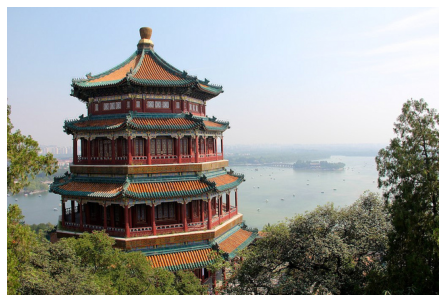

In [3]:
example_CQ = ColorQuant()
example_CQ.show_image(example_CQ.image_original)

Now let's try compressing it. There are a lot of unique colors in the original image (almost 10,000). Suppose we wanted to use only 64? How should we choose them? Probably the simplest thing to do would be to pick 64 colors from the picture at random, and then assign to each pixel whichever of these 64 is the closest to the original color. We can do better than that, though, by using some of the clustering techniques we looked at earlier.

Look at the sky in this photo - I see a gradient of pretty similar colors. It would be good if we could make sure we got at least one representative blue hue in our set of 64, maybe even 2 or 3. If we could find the mean of the blue, that might make a good choice. We can use KMeans to try to find this. The following line picks 64 colors at random and compares the result to doing KMeans on 64 clusters, using each pixel as a data point. 

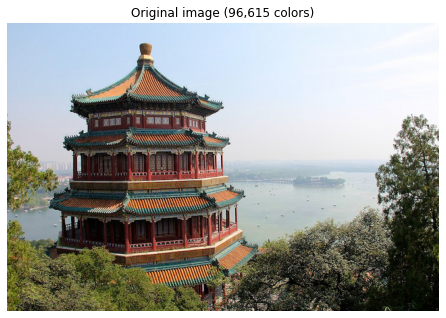

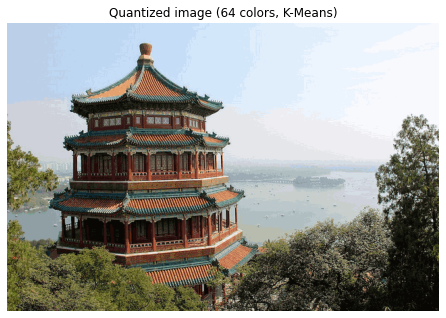

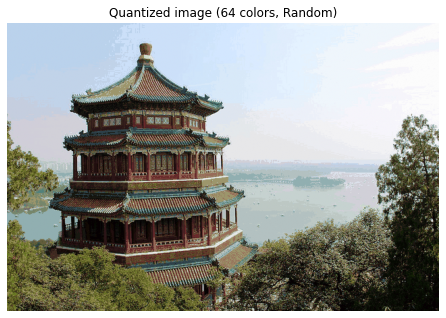

In [4]:
example_CQ.compress(64)

As we expected, the KMeans version looks better. Try running it again with a different number of colors. What's the minimum you need before it starts to look really bad? What about the minimum so that you can't tell the difference between the compressed and original image?

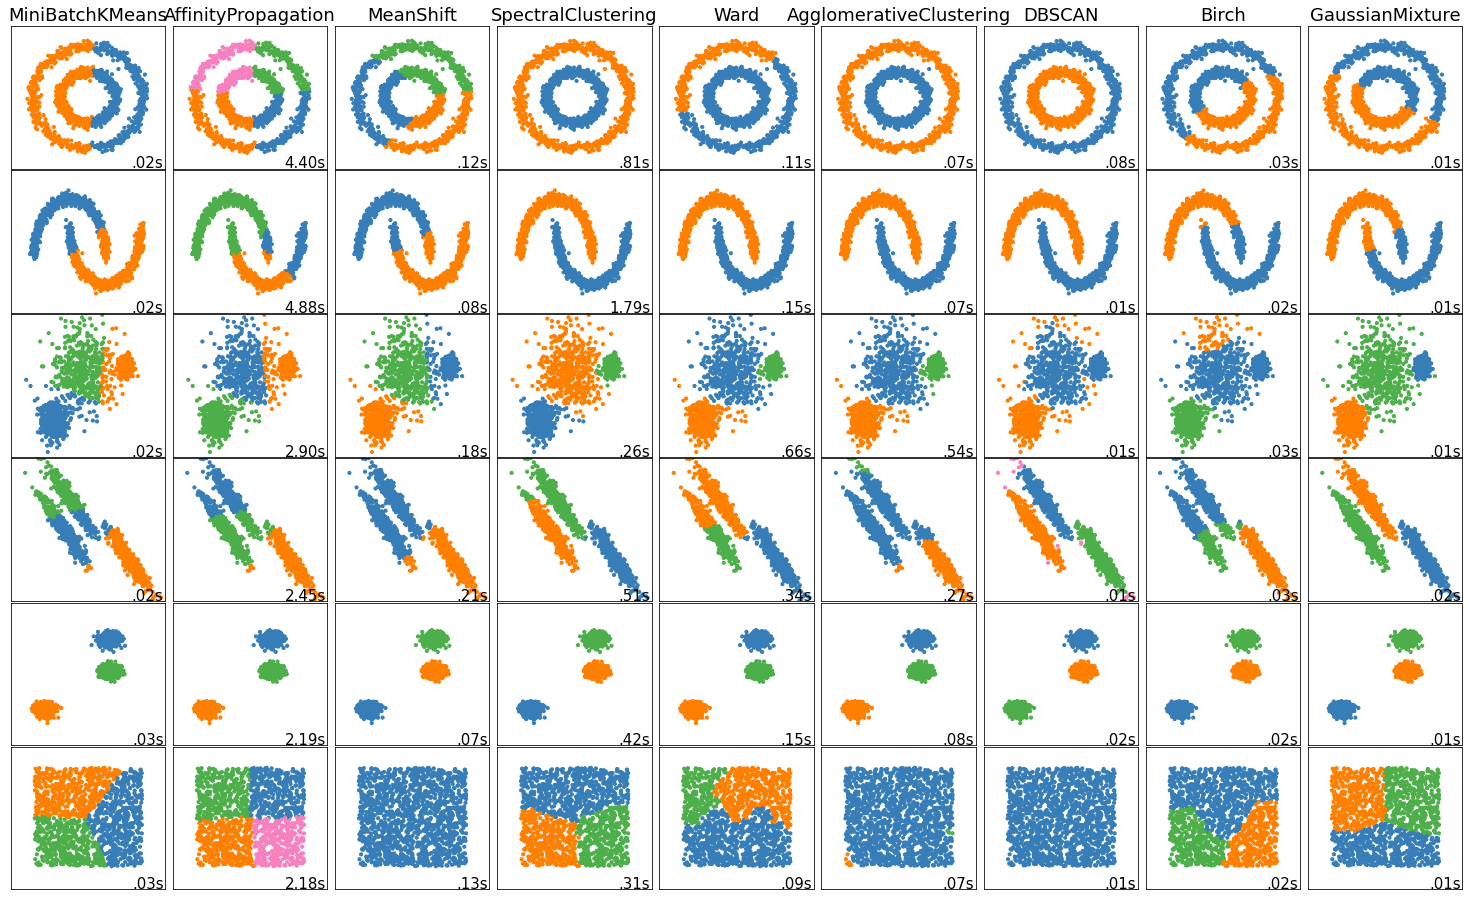

In [5]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()